# Import depedensi

In [46]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt


# KONFIGURASI

In [ ]:
MODEL_PATH = "models/efficientnet_b1.pth"
EXCEL_PATH = "models/Nama_NIM_sorted_AZ.xlsx"

INPUT_SIZE = 224

DEVICE = "cpu"

TEST_CSV_PATH = "test.csv"      
TEST_IMAGE_DIR = "test"         
OUTPUT_CSV_PATH = "jawaban.csv" 

EVAL_DIR = "."  

REPORT_PATH = os.path.join(EVAL_DIR, "models/classification_report_EfficientNet-B1-weight.txt")
CM_PATH      = os.path.join(EVAL_DIR, "models/confusion_matrix.png")
ACC_PATH     = os.path.join(EVAL_DIR, "models/accuracy_curve.png")
LOSS_PATH    = os.path.join(EVAL_DIR, "models/loss_curve.png")


# BUILD MODEL (EfficientNet-B1)

In [ ]:
def build_model(num_classes: int):
    """
    Bangun arsitektur EfficientNet-B1 yang sama seperti saat training.
    """
    try:
        weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1
        model = models.efficientnet_b1(weights=weights)
    except Exception:
        # fallback untuk versi torchvision lama
        model = models.efficientnet_b1(pretrained=True)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

def get_inference_transform(input_size=224):
    """
    Transform harus konsisten dengan transform untuk val (training).
    """
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]    
        ),
    ])
    return transform


# LOAD MODEL AND CLASS NAMES

In [ ]:
def load_model_and_classes(model_path=MODEL_PATH, device=DEVICE):
    """
    Load model dan daftar kelas (class_names) dari file .pth.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file tidak ditemukan: {model_path}")

    checkpoint = torch.load(model_path, map_location=device)

    class_names = checkpoint.get("class_names", None)
    if class_names is None:
        raise KeyError("class_names tidak ditemukan di checkpoint. Pastikan saat training disimpan.")

    num_classes = len(class_names)
    model = build_model(num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    print(f"[INFO] Model berhasil dimuat dari: {model_path}")
    print(f"[INFO] Jumlah kelas: {num_classes}")
    return model, class_names

def load_nim_name_mapping(excel_path=EXCEL_PATH):
    """
    Baca Excel berisi kolom 'Nama' dan 'NIM',
    buat mapping dari NIM (string) ke Nama.
    """
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"File Excel tidak ditemukan: {excel_path}")

    df = pd.read_excel(excel_path)

    if "NIM" not in df.columns or "Nama" not in df.columns:
        raise KeyError("Excel harus memiliki kolom 'NIM' dan 'Nama'.")

    nim_to_name = {}
    for _, row in df.iterrows():
        nim_str = str(row["NIM"]).strip()
        nama_str = str(row["Nama"]).strip()
        nim_to_name[nim_str] = nama_str

    print(f"[INFO] Mapping NIM->Nama dimuat. Total entri: {len(nim_to_name)}")
    return nim_to_name


In [50]:
def predict_image(
    image_path: str,
    model: torch.nn.Module,
    class_names,
    nim_to_name: dict,
    device: str = DEVICE,
    topk: int = 3,
    verbose: bool = True
):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")

    transform = get_inference_transform(INPUT_SIZE)
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probs, k=min(topk, probs.shape[1]), dim=1)

    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    results = []
    for prob, idx in zip(top_probs, top_indices):
        nim = class_names[idx]
        nama = nim_to_name.get(nim, "(Nama tidak ditemukan di Excel)")
        results.append({
            "nim": nim,
            "nama": nama,
            "prob": float(prob)
        })

    main = results[0]

    if verbose:
        print("\n=== HASIL PREDIKSI ===")
        print(f"Gambar         : {image_path}")
        print(f"Prediksi NIM   : {main['nim']}")
        print(f"Prediksi Nama  : {main['nama']}")
        print(f"Probabilitas   : {main['prob']:.4f}")
        print("\nTop-k prediksi:")
        for i, r in enumerate(results):
            print(f"{i+1}. NIM={r['nim']}, Nama={r['nama']}, Prob={r['prob']:.4f}")

    return results


# PREDICT IMAGE

In [ ]:
def predict_from_csv(
    model,
    class_names,
    nim_to_name,
    csv_path: str = TEST_CSV_PATH,
    image_dir: str = TEST_IMAGE_DIR,
    output_path: str = OUTPUT_CSV_PATH,
    device: str = DEVICE
):
    """
    Membaca file CSV (test.csv) yang berisi kolom 'filename' dan 'label',
    lalu melakukan klasifikasi untuk setiap filename dan menyimpan hasilnya
    ke file CSV baru (jawaban.csv) dengan kolom:
    - filename
    - label  (berisi NIM hasil prediksi / nama kelas)
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File CSV test tidak ditemukan: {csv_path}")

    df_test = pd.read_csv(csv_path)

    if "filename" not in df_test.columns:
        raise KeyError("File test.csv harus memiliki kolom 'filename'.")

    results_rows = []
    total = len(df_test)
    print(f"\n[INFO] Memulai prediksi untuk {total} gambar dari '{csv_path}'")

    for idx, row in df_test.iterrows():
        filename = str(row["filename"]).strip()

        if os.path.isabs(filename) or image_dir is None or image_dir == "":
            image_path = filename
        else:
            image_path = os.path.join(image_dir, filename)

        try:
            preds = predict_image(
                image_path=image_path,
                model=model,
                class_names=class_names,
                nim_to_name=nim_to_name,
                device=device,
                topk=3,
                verbose=False
            )
            top1_nim = preds[0]["nim"]
        except FileNotFoundError as e:
            print(f"[PERINGATAN] {e}")
            top1_nim = ""

        results_rows.append({
            "filename": filename,
            "label": top1_nim
        })

        if (idx + 1) % 10 == 0 or (idx + 1) == total:
            print(f"  -> Proses {idx+1}/{total} selesai")

    df_out = pd.DataFrame(results_rows)
    df_out.to_csv(output_path, index=False)
    print(f"\n[INFO] File jawaban disimpan ke: {output_path}")
    print(f"[INFO] Total baris: {len(df_out)}")


# LOAD FILE EVALUASI MODEL

In [ ]:
def load_classification_report(path=REPORT_PATH):
    """
    Membaca classification report (.txt) dan mengembalikan sebagai string.
    """
    if not os.path.exists(path):
        print(f"[PERINGATAN] File classification report tidak ditemukan: {path}")
        return None

    with open(path, "r") as f:
        content = f.read()

    print(f"[INFO] classification report berhasil dimuat: {path}")
    return content


def load_image(path: str):
    """
    Membaca file gambar (PNG) dan mengembalikan object PIL.Image.
    """
    if not os.path.exists(path):
        print(f"[PERINGATAN] File gambar tidak ditemukan: {path}")
        return None

    try:
        img = Image.open(path)
        print(f"[INFO] Gambar berhasil dimuat: {path}")
        return img
    except Exception as e:
        print(f"[ERROR] Gagal load gambar {path}: {e}")
        return None


def load_evaluation_assets(
    report_path=REPORT_PATH,
    cm_path=CM_PATH,
    acc_path=ACC_PATH,
    loss_path=LOSS_PATH
):
    """
    Memuat seluruh file evaluasi sekaligus dan mengembalikan dict.
    """
    assets = {
        "report": load_classification_report(report_path),
        "confusion_matrix": load_image(cm_path),
        "accuracy_curve": load_image(acc_path),
        "loss_curve": load_image(loss_path),
    }
    return assets


# TAMPILKAN HASIL EVALUASI PELATIHAN MODEL

[INFO] classification report berhasil dimuat: .\models/classification_report_EfficientNet-B1-weight.txt
[INFO] Gambar berhasil dimuat: .\models/confusion_matrix.png
[INFO] Gambar berhasil dimuat: .\models/accuracy_curve.png
[INFO] Gambar berhasil dimuat: .\models/loss_curve.png
=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

   119140141       0.00      0.00      0.00         1
   120140156       1.00      1.00      1.00         1
   121140135       0.00      0.00      0.00         1
   122140001       0.00      0.00      0.00         1
   122140005       0.00      0.00      0.00         1
   122140006       0.00      0.00      0.00         1
   122140008       0.00      0.00      0.00         1
   122140009       0.00      0.00      0.00         1
   122140010       0.00      0.00      0.00         1
   122140012       1.00      1.00      1.00         1
   122140016       0.00      0.00      0.00         1
   122140018       1.00      1.00      1.

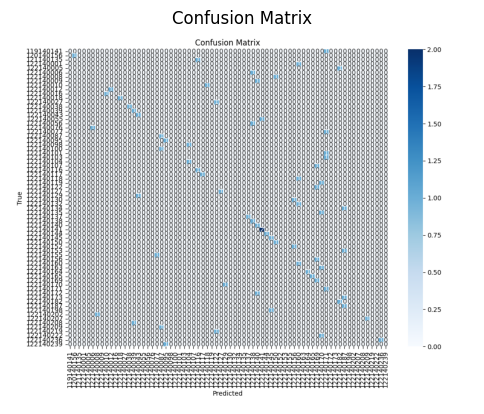

In [ ]:
assets = load_evaluation_assets()

if assets["report"] is not None:
    print("=== CLASSIFICATION REPORT ===\n")
    print(assets["report"])

if assets["confusion_matrix"] is not None:
    plt.figure(figsize=(6, 5))
    plt.imshow(assets["confusion_matrix"])
    plt.axis("off")
    plt.title("Confusion Matrix")
    plt.show()

if assets["accuracy_curve"] is not None:
    plt.figure(figsize=(6, 4))
    plt.imshow(assets["accuracy_curve"])
    plt.axis("off")
    plt.title("Accuracy Curve")
    plt.show()

if assets["loss_curve"] is not None:
    plt.figure(figsize=(6, 4))
    plt.imshow(assets["loss_curve"])
    plt.axis("off")
    plt.title("Loss Curve")
    plt.show()


# MENGGUNAKAN MODEL

In [ ]:
model, class_names = load_model_and_classes(MODEL_PATH, DEVICE)
nim_to_name = load_nim_name_mapping(EXCEL_PATH)

# Panggil langsung
predict_from_csv(
    model=model,
    class_names=class_names,
    nim_to_name=nim_to_name,
    csv_path=TEST_CSV_PATH,
    image_dir=TEST_IMAGE_DIR,
    output_path=OUTPUT_CSV_PATH,
    device=DEVICE
)
